In [1]:
!pip install --upgrade tensorflow --user
!pip install tf-quant-finance
!pip install QuantLib-Python

In [2]:
import os
# reduce number of threads
os.environ['TF_NUM_INTEROP_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tf_quant_finance as tff 
import tensorflow as tf
import functools
import pandas as pd
import time
import QuantLib as ql

In [3]:
!nvidia-smi

Fri Apr  8 13:13:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#@title Set up parameters

dtype = tf.float64 #@param
num_samples = 200000 #@param
num_timesteps = 100#100 #@param
nb_options = 20

# expiries =tf.constant( [0.0, 0.5, 1.0], dtype=dtype) # This can be a rank 1 Tensor
dt = 1. / num_timesteps
times = [1.0]
# times = tf.linspace(tf.constant(0.0, dtype=dtype), tf.constant(1.0, dtype=dtype), num_timesteps)
rate = tf.constant(0.03, dtype=dtype)
sigma = tf.constant(0.1, dtype=dtype)
spot = tf.constant(700, dtype=dtype)
strikes = tf.linspace(0.5*spot, 1.5*spot, nb_options)

def set_up_pricer(times, watch_params=False):
    """Set up European option pricing function under Black-Scholes model.
    
    Args:
        expiries: List of expiries at which to to sample the trajectories.
        watch_params: A Python bool. When `True`, gradients of the price function wrt the inputs
          are computed more efficiently. 
    Returns:
     A callable that accepts a rank 1 tensor of strikes, and scalar values for 
     the spots and  volatility values. The callable outputs prices of
     the European call options on the grid `expiries x strikes`.
    """
    def price_eu_options(strikes, spot, sigma):
        # Define drift and volatility functions. 
        def drift_fn(t, x):
          del t, x
          return rate - 0.5 * sigma**2
        def vol_fn(t, x):
          del t, x
          return tf.reshape(sigma, [1, 1])
        # Use GenericItoProcess class to set up the Ito process
        process = tff.models.GenericItoProcess(
            dim=1,
            drift_fn=drift_fn,
            volatility_fn=vol_fn,
            dtype=dtype)
        log_spot = tf.math.log(tf.reduce_mean(spot))
        if watch_params:
            watch_params_list = [sigma]
        else:
            watch_params_list = None
        paths = process.sample_paths(
            times=times, num_samples=num_samples,
            initial_state=log_spot, 
            watch_params=watch_params_list,
            # Select a random number generator
            random_type=tff.math.random.RandomType.PSEUDO_ANTITHETIC,
            time_step=dt)
        prices = (tf.exp(-tf.expand_dims(rate * times, axis=-1))
                  * tf.reduce_mean(tf.nn.relu(tf.math.exp(paths) - strikes), 0))
        return prices
    return price_eu_options

price_eu_options = tf.function(set_up_pricer(times, watch_params=True),
                               input_signature=[
                                                tf.TensorSpec([None], dtype=tf.float64),
                                                tf.TensorSpec([], dtype=tf.float64),
                                                tf.TensorSpec([], dtype=tf.float64)
                               ])
price_eu_options_xla = tf.function(set_up_pricer(times),
                               input_signature=[
                                                tf.TensorSpec([None], dtype=tf.float64),
                                                tf.TensorSpec([], dtype=tf.float64),
                                                tf.TensorSpec([], dtype=tf.float64)
                               ], jit_compile=True)
# price_eu_options_xla = tf.function(set_up_pricer(times), jit_compile=True)
# price_eu_options = set_up_pricer(times)
# price_eu_options_xla = set_up_pricer(times)

In [5]:
#@title Pricing times on CPU and GPU platforms

time_start = time.time()
with tf.device("/cpu:0"):
    price_cpu_nograph = set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_cpu_nograph = time_end - time_start
print(price_cpu_nograph[:10].numpy())

time_start = time.time()
with tf.device("/gpu:0"):
    set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_gpu_nograph = time_end - time_start

# GPU without XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_cpu = time_end - time_start

print('time_price_cpu_nograph', time_price_cpu_nograph, nb_options/time_price_cpu_nograph)
print('time_price_gpu_nograph', time_price_gpu_nograph, nb_options/time_price_gpu_nograph)

print('time_price_gpu0', time_price_gpu0, nb_options/time_price_gpu0)
print('time_price_gpu', time_price_gpu, nb_options/time_price_gpu)

print('time_price_cpu0', time_price_cpu0, nb_options/time_price_cpu0)
print('time_price_cpu', time_price_cpu, nb_options/time_price_cpu)


[[3.60345045e+02 3.24591788e+02 2.88838532e+02 2.53085275e+02
  2.17333201e+02 1.81600120e+02 1.46023513e+02 1.11203405e+02
  7.86623392e+01 5.06922844e+01 2.93114027e+01 1.50899570e+01
  6.89531752e+00 2.78983017e+00 1.00670274e+00 3.26936605e-01
  9.77744200e-02 2.62518328e-02 6.73473872e-03 1.49167486e-03]]
time_price_cpu_nograph 5.370177507400513 3.7242716786248646
time_price_gpu_nograph 2.2906999588012695 8.730955760118869
time_price_gpu0 15.704607963562012 1.2735115735715403
time_price_gpu 1.2771110534667969 15.66034523443264
time_price_cpu0 3.213871717453003 6.223023741548099
time_price_cpu 2.6632704734802246 7.509563973750301


In [6]:
#@title Pricing times on CPU and GPU platforms

time_start = time.time()
with tf.device("/cpu:0"):
    price_cpu_nograph = set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_cpu_nograph = time_end - time_start
print(price_cpu_nograph[:10].numpy())

time_start = time.time()
with tf.device("/gpu:0"):
    set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_gpu_nograph = time_end - time_start

# GPU without XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    prices = price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_cpu = time_end - time_start

print('time_price_cpu_nograph', time_price_cpu_nograph, nb_options/time_price_cpu_nograph)
print('time_price_gpu_nograph', time_price_gpu_nograph, nb_options/time_price_gpu_nograph)

print('time_price_gpu0 XLA', time_price_gpu0, nb_options/time_price_gpu0)
print('time_price_gpu XLA', time_price_gpu, nb_options/time_price_gpu)

print('time_price_cpu0 XLA', time_price_cpu0, nb_options/time_price_cpu0)
print('time_price_cpu XLA', time_price_cpu, nb_options/time_price_cpu)


[[3.60346009e+02 3.24592752e+02 2.88839496e+02 2.53086305e+02
  2.17334392e+02 1.81603152e+02 1.46032679e+02 1.11228501e+02
  7.86583107e+01 5.06685264e+01 2.92886000e+01 1.50658646e+01
  6.88566483e+00 2.82018112e+00 1.03780880e+00 3.40721651e-01
  1.01481789e-01 2.99172402e-02 8.07909520e-03 1.77580255e-03]]
time_price_cpu_nograph 3.040762424468994 6.5772977984271765
time_price_gpu_nograph 1.0664794445037842 18.753291592324764
time_price_gpu0 XLA 1.107900857925415 18.052156794472324
time_price_gpu XLA 0.02626323699951172 761.5207523875232
time_price_cpu0 XLA 1.4234263896942139 14.050603631352148
time_price_cpu XLA 1.0995428562164307 18.189377418921868


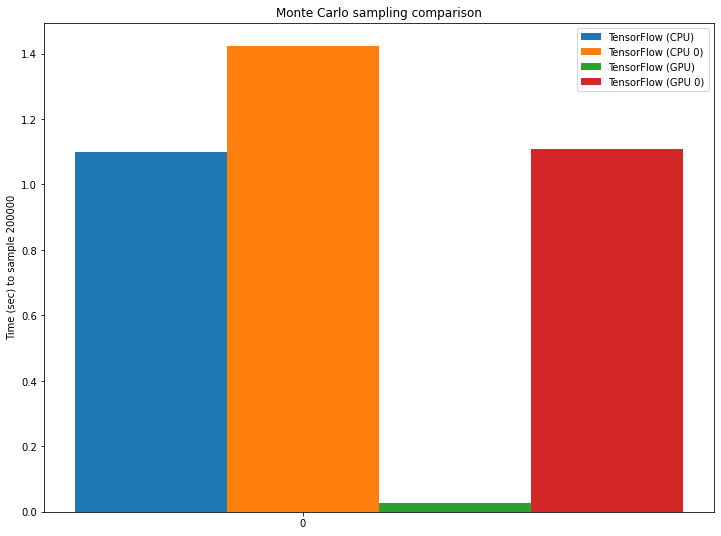

In [7]:
#@title Plot the results

ind = np.arange(1)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

fig.set_figheight(9)
fig.set_figwidth(12)

ax.bar(ind - width/8, [time_price_cpu], width / 8,
       label='TensorFlow (CPU)')
ax.bar(ind, [time_price_cpu0], width / 8,
       label='TensorFlow (CPU 0)')
ax.bar(ind + width/8, [time_price_gpu], width / 8,
       label='TensorFlow (GPU)')
ax.bar(ind + width/4, [time_price_gpu0], width / 8,
       label='TensorFlow (GPU 0)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (sec) to sample {}'.format(num_samples))
ax.set_title('Monte Carlo sampling comparison')
ax.set_xticks(ind)
ax.legend()


plt.show()

In [8]:
# Delta
@tf.function
def delta_fn(spot):
    fn = lambda spot: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, spot,
                                 use_gradient_tape=True)
# Theta # not tested in https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb
# Rho # not tested in https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb
# Vega
@tf.function
def vega_fn(sigma):
    fn = lambda sigma: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, sigma,
                                 use_gradient_tape=True)



# Delta
@tf.function(jit_compile=True)
def delta_fn_xla(spot):
    fn = lambda spot: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, spot,
                                 use_gradient_tape=True)
# Theta # not tested in https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb
# Rho # not tested in https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb
# Vega
@tf.function(jit_compile=True)
def vega_fn_xla(sigma):
    fn = lambda sigma: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, sigma,
                                 use_gradient_tape=True)

In [9]:
# Delta CPU
## warmup
with tf.device("/cpu:0"):
    delta_fn(spot)
## measure time
time_start = time.time()
with tf.device("/cpu:0"):
    deltas_cpu = delta_fn(spot)
time_end = time.time()
time_delta_cpu = time_end - time_start


# Vega CPU
## warmup
with tf.device("/cpu:0"):
    vega_fn(sigma)
## measure time
time_start = time.time()
with tf.device("/cpu:0"):
    vegas_cpu = vega_fn(sigma)
time_end = time.time()
time_vega_cpu = time_end - time_start


# Delta GPU
## warmup
with tf.device("/gpu:0"):
    delta_fn(spot)
## measure time
time_start = time.time()
with tf.device("/gpu:0"):
    deltas_gpu = delta_fn(spot)
time_end = time.time()
time_delta_gpu = time_end - time_start

# Vega GPU
## warmup
with tf.device("/gpu:0"):
    vega_fn(sigma)
## measure time
time_start = time.time()
with tf.device("/gpu:0"):
    vegas_gpu = vega_fn(sigma)
time_end = time.time()
time_vega_gpu = time_end - time_start



print('time_delta_cpu', time_delta_cpu, nb_options/time_delta_cpu)
print('time_vega_cpu', time_vega_cpu, nb_options/time_vega_cpu)
print('time_delta_gpu', time_delta_gpu, nb_options/time_delta_gpu)
print('time_vega_gpu', time_vega_gpu, nb_options/time_vega_gpu)

print(deltas_cpu)
print(vegas_cpu)
print(deltas_gpu)
print(vegas_gpu)

time_delta_cpu 7.3755786418914795 2.71165165081488
time_vega_cpu 7.392932415008545 2.7052864651376476
time_delta_gpu 1.4602220058441162 13.696547456452365
time_vega_gpu 1.4565134048461914 13.731421855408197
tf.Tensor(
[[9.99964628e-01 9.99964628e-01 9.99964628e-01 9.99958347e-01
  9.99874388e-01 9.98825322e-01 9.91618782e-01 9.61379582e-01
  8.80678378e-01 7.31133526e-01 5.35862689e-01 3.40895346e-01
  1.86337556e-01 8.88884143e-02 3.74422005e-02 1.38467557e-02
  4.56961861e-03 1.47151430e-03 4.34018184e-04 1.56715564e-04]], shape=(1, 20), dtype=float64)
tf.Tensor(
[[1.31584811e-01 1.31584811e-01 1.31584811e-01 1.31584811e-01
  4.23372694e-01 3.28408759e+00 1.63182080e+01 5.94456003e+01
  1.40188643e+02 2.31011312e+02 2.78435323e+02 2.56880087e+02
  1.88660345e+02 1.13934688e+02 5.77812284e+01 2.53162051e+01
  1.02079022e+01 4.08137349e+00 1.42391901e+00 4.21807475e-01]], shape=(1, 20), dtype=float64)
tf.Tensor(
[[9.99978203e-01 9.99978203e-01 9.99978203e-01 9.99975076e-01
  9.99873703

In [10]:
# GPU without XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
    delta_fn(spot)
    vega_fn(sigma)
time_end = time.time()
time_pricegreek_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
    delta_fn(spot)
    vega_fn(sigma)
time_end = time.time()
time_pricegreek_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
    deltas = delta_fn(spot)
    vegas = vega_fn(sigma)
time_end = time.time()
time_pricegreek_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options(strikes, spot, sigma)
    delta_fn(spot)
    vega_fn(sigma)
time_end = time.time()
time_pricegreek_cpu = time_end - time_start

print('time_pricegreek_gpu0', time_pricegreek_gpu0, nb_options/time_pricegreek_gpu0)
print('time_pricegreek_cpu0', time_pricegreek_cpu0, nb_options/time_pricegreek_cpu0)
print('time_pricegreek_gpu', time_pricegreek_gpu, nb_options/time_pricegreek_gpu)
print('time_pricegreek_cpu', time_pricegreek_cpu, nb_options/time_pricegreek_cpu)

print('prices', prices)
print('deltas', deltas)
print('vegas', vegas)

time_pricegreek_gpu0 3.466047525405884 5.7702613289060265
time_pricegreek_cpu0 17.965393543243408 1.1132514270761291
time_pricegreek_gpu 3.4605677127838135 5.779398543804604
time_pricegreek_cpu 17.200430154800415 1.1627616181690819
prices tf.Tensor(
[[3.60321883e+02 3.24568626e+02 2.88815370e+02 2.53062113e+02
  2.17309958e+02 1.81577729e+02 1.46009535e+02 1.11193438e+02
  7.86063012e+01 5.05463168e+01 2.91305327e+01 1.49453927e+01
  6.83729125e+00 2.80727800e+00 1.02489781e+00 3.42240399e-01
  1.03588597e-01 2.61590216e-02 5.76420475e-03 1.53468429e-03]], shape=(1, 20), dtype=float64)
deltas tf.Tensor(
[[9.99987679e-01 9.99987679e-01 9.99987679e-01 9.99981317e-01
  9.99910121e-01 9.98940747e-01 9.91450230e-01 9.60768439e-01
  8.79370237e-01 7.31453910e-01 5.36187848e-01 3.40856754e-01
  1.87658289e-01 8.91997114e-02 3.80818959e-02 1.41798806e-02
  4.52543357e-03 1.38490126e-03 4.17143091e-04 8.21343227e-05]], shape=(1, 20), dtype=float64)
vegas tf.Tensor(
[[-3.27641874e-01 -3.27641874

In [11]:
# GPU with XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
    delta_fn_xla(spot)
    vega_fn_xla(sigma)
time_end = time.time()
time_pricegreek_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
    delta_fn_xla(spot)
    vega_fn_xla(sigma)
time_end = time.time()
time_pricegreek_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options_xla(strikes, spot, sigma)
    deltas = delta_fn_xla(spot)
    vegas = vega_fn_xla(sigma)
time_end = time.time()
time_pricegreek_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
    delta_fn_xla(spot)
    vega_fn_xla(sigma)
time_end = time.time()
time_pricegreek_cpu = time_end - time_start

print('time_pricegreek_gpu0 XLA', time_pricegreek_gpu0, nb_options/time_pricegreek_gpu0)
print('time_pricegreek_cpu0 XLA', time_pricegreek_cpu0, nb_options/time_pricegreek_cpu0)
print('time_pricegreek_gpu XLA', time_pricegreek_gpu, nb_options/time_pricegreek_gpu)
print('time_pricegreek_cpu XLA', time_pricegreek_cpu, nb_options/time_pricegreek_cpu)

print('prices', prices)
print('deltas', deltas)
print('vegas', vegas)

time_pricegreek_gpu0 XLA 1.8622572422027588 10.73965483755785
time_pricegreek_cpu0 XLA 4.501050710678101 4.443406947749523
time_pricegreek_gpu XLA 0.0677492618560791 295.2061683341486
time_pricegreek_cpu XLA 3.402479648590088 5.878066018201625
prices tf.Tensor(
[[3.60364956e+02 3.24611699e+02 2.88858443e+02 2.53105190e+02
  2.17353170e+02 1.81621329e+02 1.46053677e+02 1.11256098e+02
  7.87217244e+01 5.07459684e+01 2.93871683e+01 1.51423208e+01
  6.94772334e+00 2.84807847e+00 1.04515832e+00 3.43913318e-01
  1.02697380e-01 2.75628766e-02 6.52020910e-03 1.58466673e-03]], shape=(1, 20), dtype=float64)
deltas tf.Tensor(
[[9.99991518e-01 9.99991518e-01 9.99991518e-01 9.99988352e-01
  9.99897718e-01 9.98804311e-01 9.91674608e-01 9.60452582e-01
  8.80106469e-01 7.31909996e-01 5.36003946e-01 3.40205763e-01
  1.86967694e-01 9.00207121e-02 3.76038069e-02 1.38242262e-02
  4.69046419e-03 1.51265460e-03 4.61982970e-04 1.49278655e-04]], shape=(1, 20), dtype=float64)
vegas tf.Tensor(
[[-4.49307979e-01

In [ ]:
# @title Monte Carlo sampling in QuantLib

def ql_price(strike):
    num_samples = 200000 #@param
    num_timesteps = 100#100 #@param
    expiry = 1.0

    calculation_date = ql.Date(1, 1, 2010)
    maturity_date = ql.Date(1, 1, 2011)
    day_count = ql.Thirty360()
    calendar = ql.NullCalendar()

    ql_strike_price = strike
    sigma_ql = 0.1
    ql_volatility = ql.SimpleQuote(sigma_ql)
    ql_risk_free_rate = 0.03
    option_type = ql.Option.Call

    ql.Settings.instance().evaluationDate = calculation_date
    payoff = ql.PlainVanillaPayoff(option_type, ql_strike_price)

    eu_exercise = ql.EuropeanExercise(maturity_date)
    european_option_ql = ql.VanillaOption(payoff, eu_exercise)

    flat_ts = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, ql_risk_free_rate, day_count)
    )
    flat_vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(calculation_date, calendar,
                            ql.QuoteHandle(ql_volatility), day_count)
    )

    spot_ql = 700
    spot_price = ql.SimpleQuote(spot_ql)
    spot_handle = ql.QuoteHandle(
        spot_price
    )
    bsm_process = ql.BlackScholesProcess(spot_handle,
                                          flat_ts,
                                          flat_vol_ts)

    # Compute the same price number_of_options times

    engine = ql.MCEuropeanEngine(bsm_process, "PseudoRandom",
                                 timeSteps=num_timesteps,
                                 requiredSamples=num_samples,
                                 seed=42)

    european_option_ql.setPricingEngine(engine)
    price_ql = european_option_ql.NPV()
    return price_ql

ql_prices = []
t = time.time()
for strike in strikes:
    price_ql = ql_price(strike.numpy())
    ql_prices.append(price_ql)
time_price_ql = time.time() - t
print(ql_prices)
print("Time (seconds) to price a European Call Option using QuantLib: ", time_price_ql, nb_options/time_price_ql)